In [1]:
import os
import glob
import numpy as np
import pandas as pd
import astropy.io.fits as pf
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
# %matplotlib qt

In [2]:
def get_tles(camid):

    with open('../test_data/3leComplete.txt') as f:
        all_tles = f.readlines()
        f.close()   

    # Split TLE list into individual lists for each TLE
    all_tles = [i.strip() for i in all_tles]
    tles = [all_tles[x:x+3] for x in range(0, len(all_tles), 3)]

    # Reduce TLEs to Starlink only
    starlink_tles = []
    for tle in tles:
        if "STARLINK" in tle[0]:
            starlink_tles.append(tle)

    # Obtain satellite passages
    passed_sats = pd.read_pickle(f'../test_data/passages/passed_satellites_20221023{camid}.p')
    keys = list(passed_sats)

    # Find any Starlink TLEs in the passages
    idx = []
    starlinks = np.asarray(starlink_tles).flatten()
    for key in keys:
        mascara_tle1 = passed_sats[key]['TLE line1'].strip()
        i = np.where(starlinks == mascara_tle1)[0] #this is not going to be fast for big lists...
        if i.size > 0:
            idx.append(i[0] - 1) #appending the name of the starlink sat

    # Now have indices for the flattened Starlink TLE list --> divide by 3 to get indices for the original list
    orig_idx = [int(x/3) for x in idx]
    slk_mas_tles = res_list = [starlink_tles[i] for i in orig_idx]

    # Remove 0 labeling of first line of TLE because that's the proper format
    for tle in slk_mas_tles:
        tle[0] = tle[0][2:]
        
    return slk_mas_tles

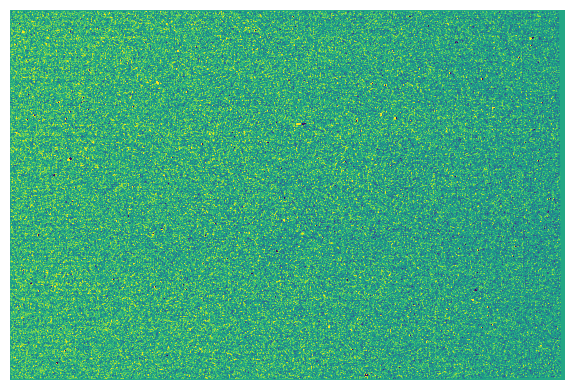

In [3]:
image = '48509045'

plt.figure(figsize=[6,4])
data, header = pf.getdata(f'../diff_{image}LSC.fits.gz', header=True) 
plt.imshow(data, vmin=-15, vmax=10)
plt.axis('off')
plt.tight_layout()
# plt.savefig('diff_image_48506263.png', dpi=300, format='png')
plt.show()

In [4]:
known = pd.read_pickle('../known_satellites20221023LSC.p')
sat_no = list(known['positive'])[0]
print(list(known))
print(list(known['positive']))
print(list(known['positive'][sat_no]))
print(list(known['positive'][sat_no]['pixelpositions']))
print(list(known['positive'][sat_no]['pixelpositions'][2459876.721782385]))
print(list(known['positive'][sat_no]['pixelpositions'][2459876.721782385]['SGP4']))
print(list(known['positive'][sat_no]['pixelpositions'][2459876.721782385]['FOTOS']))

['negative', 'positive']
['43563U']
[2459876.721782385, 2459876.721856261, 'vmag', 'pixelpositions']
[2459876.721782385, 2459876.721856261]
['FOTOS', 'SGP4', 'lstseq']
[432.2145166738334, 1073.191517097767]
[435, 1076]


In [5]:
pxlpos = pd.read_pickle('../pixel_position_known_satellites20221023LSC.p')
pxlpos

{'negative': {},
 'positive': {'43563U': {2459876.721819323: {'start': [435, 1076],
    'end': [413, 1081]}}}}

In [6]:
print(list(known['positive'][sat_no][2459876.721782385]))
RA  = list(known['positive'][sat_no][2459876.721782385])[0][0]
dec = list(known['positive'][sat_no][2459876.721782385])[0][1]
lst = list(known['positive'][sat_no][2459876.721782385])[1]

[array([ 73.68554217, -21.02120872]), 2.7800526077291714]


ProduceSkyPositions $\rightarrow$ MatchKnownPositions $\rightarrow$ astro.pix2world

astro.pix2world comes from mascara_astrometry (import bringreduce.mascara_astrometry as astrometry)


```
    def pix2world(self, lst, xpix, ypix, jd=None):
        
        # Convert to wcs-only pixel coordinates.
        xwcs, ywcs = pix2wcs(self.polpars, xpix, ypix)
        
        # Convert to world coordinates.
        ra, dec = wcs2world(self.wcspars, xwcs, ywcs, lst, jd)
        
        return ra, dec
```

pixelpositions = pixel position of end points of track
 - FOTOS $\rightarrow$ x_min, y_min 
 - SGP4 $\rightarrow$ x_max, y_max
 
 
``` 

from STD import LineSegments

#Initiate the Satellite Track Determination module    
readdata = LineSegments(data, nx, ny, starcat, astrometry, user, target, rootdir, curlstseq, midlst, midJD, 
                        plots=True, verbal=True)
        
x_min, y_min, x_max, y_max, lst = readdata.determine_endpoints(lst0, lst1, readdata.cleanedlines[line_id], 
                                                               l_x, l_y) 

```



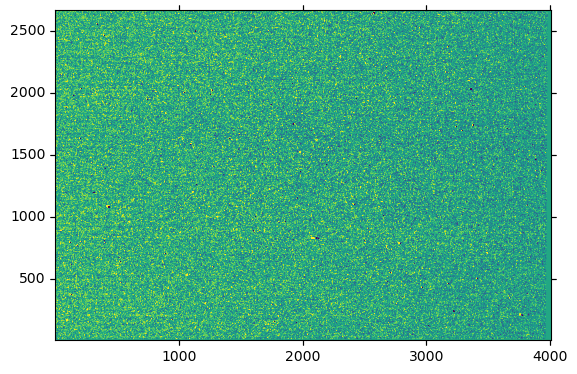

In [7]:
#### REFER TO https://joseph-long.com/writing/from-sky-coordinates-to-pixels-and-back/


# %config InlineBackend.figure_formats = ['retina']
# %config InlineBackend.print_figure_kwargs = {'facecolor': (1.0, 1.0, 1.0, 0.0)}
# import matplotlib
# from matplotlib.colors import LogNorm
# # correct image orientation and improve appearance:
# matplotlib.rcParams.update({
#     'image.origin': 'lower',
#     'image.interpolation': 'nearest',
#     'image.cmap': 'magma',
#     'font.family': 'serif',
# })
# import warnings
# warnings.simplefilter('ignore')


from astropy.wcs import WCS

data, header = pf.getdata(f'../diff_{image}LSC.fits.gz', header=True) 
wcs = WCS(header=header)
ax = plt.subplot(projection=wcs)
im = ax.imshow(data, vmin=-15, vmax=10)
# plt.colorbar(im)
plt.show()


# Look at the World Coords - it matches with the pixel coords!

In [8]:
# check if this is indeed Starlink

# Grab just the Sat number
starlinks_no = []
for sat in slk_mas_tles:
    starlinks_no.append(sat[1][2:8])

# Search for sat 
found_sat = list(known['positive'])[0]
for i, sat in enumerate(starlinks_no):
    if (sat == found_sat):
        print(i, sat)

Turns out the found satellite here is FALCON 9 R/B which is 11000km high (explains small trail)

In [9]:
print(RA, dec)

73.68554217014237 -21.02120871741862


In [10]:
# Let's draw a box around the "Starlink"

dec_ll, ra_ll = dec-2, RA-2
dec_ur, ra_ur = dec+2, RA+2

(xmin, xmax), (ymin, ymax) = wcs.all_world2pix([ra_ll, ra_ur], [dec_ll, dec_ur], 0)



/var/folders/5f/x4x1ls6j1_bgn5_rscqsv6tw0000gn/T/ipykernel_7773/2173466822.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


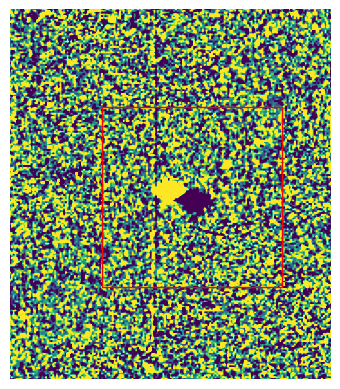

In [11]:
x0 = pxlpos['positive'][found_sat][2459876.721819323]['start'][0]
y0 = pxlpos['positive'][found_sat][2459876.721819323]['start'][1]

x1 = pxlpos['positive'][found_sat][2459876.721819323]['end'][0]
y1 = pxlpos['positive'][found_sat][2459876.721819323]['end'][1]

P = 100
# subregion = data[y0-P:y1+P, x0-P:x1+P]
# _ = plt.imshow(subregion, vmin=-15, vmax=15)

## Alternatively:
(xmin, xmax), (ymin, ymax) = wcs.all_world2pix([x0-P, x1+P], [y0-P, y1+P], 0)
ax = plt.subplot(projection=wcs)
im = ax.imshow(data, vmin=-15, vmax=15)
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
r = Rectangle((x0-P/2, y0-P/2), P, P, edgecolor='red', facecolor='none')
ax.add_patch(r)

plt.axis('off')
plt.tight_layout()
# plt.savefig('example_zoom.png', dpi=300, format='png')

plt.show()

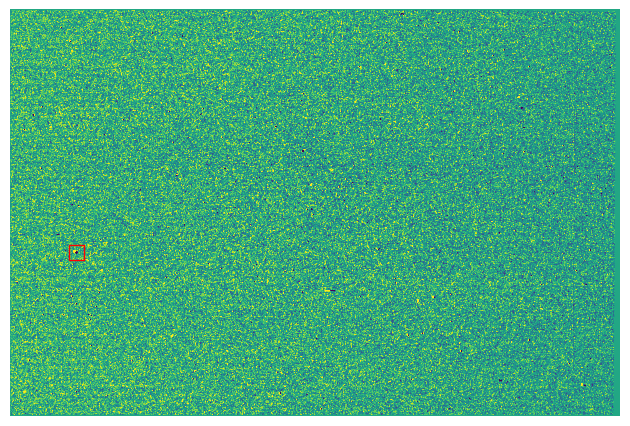

In [12]:
from matplotlib.patches import Rectangle
from astropy.wcs import WCS

data, header = pf.getdata(f'../diff_{image}LSC.fits.gz', header=True) 
wcs = WCS(header=header)
ax = plt.subplot(projection=wcs)
im = ax.imshow(data, vmin=-15, vmax=10)

r = Rectangle((x0-P/2, y0-P/2), P, P, edgecolor='red', facecolor='none')
ax.add_patch(r)

plt.axis('off')
plt.tight_layout()
# plt.savefig('example.png', dpi=300, format='png')

plt.show()

### Week of 13th March

['negative', 'positive']
['49010U', '39450U', '29092U']
[2459876.5300848032, 2459876.5301586804, 'vmag', 'pixelpositions']
[2459876.5300848032, 2459876.5301586804]


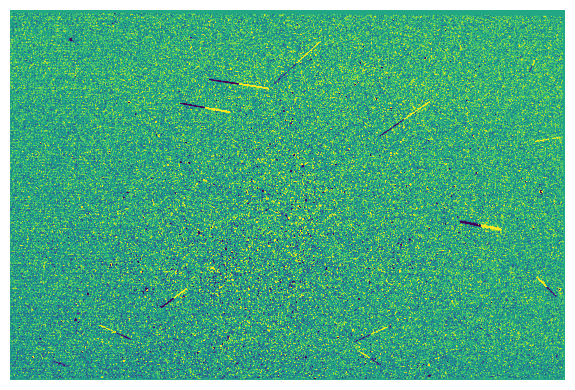

In [29]:
known = pd.read_pickle('../fov_test/known_satellites20221023LSW.p')
sat_no = list(known['positive'])[0]
print(list(known))
print(list(known['positive']))
print(list(known['positive'][sat_no]))
print(list(known['positive'][sat_no]['pixelpositions']))

# Grab just the Sat number
tles_LSW = get_tles('LSW')
starlinks_no = []
for sat in tles_LSW:
    starlinks_no.append(sat[1][2:8])

# Search for sat 
found_sat = list(known['positive'])[0]
for i, sat in enumerate(starlinks_no):
    if (sat == found_sat):
        print(i, sat)
        
plt.figure(figsize=[6,4])
data, header = pf.getdata(f'../fov_test/diff_48506450LSW.fits.gz', header=True) 
plt.imshow(data, vmin=-15, vmax=10)
plt.axis('off')
plt.tight_layout()
plt.show()

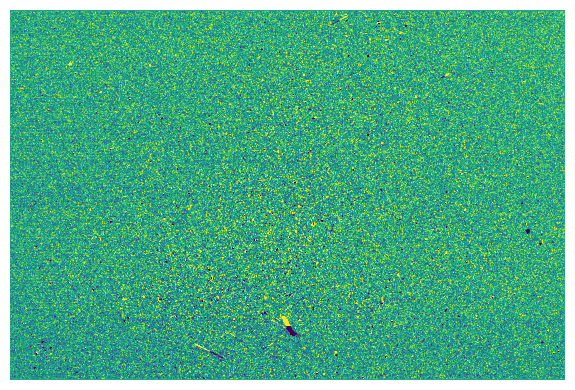

In [74]:
plt.figure(figsize=[6,4])
data, header = pf.getdata(f'../fov_test/diff_48506675LSW.fits.gz', header=True) 
plt.imshow(data, vmin=-15, vmax=10)
plt.axis('off')
plt.tight_layout()
plt.show()